# Import Dependencies

In [62]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import seaborn as sns
from matplotlib import pyplot as plt

from pathlib import Path
from tqdm import tqdm

import warnings

warnings.filterwarnings('ignore')

# Load Data

In [63]:
# industry returns
df = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 11, nrows = 1182, header=0)
df.index = pd.to_datetime(df.index, format = "%Y%m")
df = df / 100

# remove NAs
mask = (df <= -0.99)
df[mask] = np.nan

# nb of industries dataframe
nb_industries = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 2587, nrows = 1182, header=0)
nb_industries.index = pd.to_datetime(nb_industries.index, format = "%Y%m")
mask = (nb_industries <= -0.99)
nb_industries[mask] = np.nan

# average sizes dataframe
avg_size = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 3773, nrows = 1182, header=0)
avg_size.index = pd.to_datetime(avg_size.index, format = "%Y%m")
mask = (avg_size <= -0.99)
avg_size[mask] = np.nan

# sum of BE / sum of ME dataframe
be_over_me = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 4959, nrows = 99, header=0)
be_over_me.index = pd.to_datetime(be_over_me.index, format = "%Y")

In [64]:
# market cap of each industry over time
mkt_cap = nb_industries * avg_size

# momentum with monthly data
momentum = df.rolling(12).mean()

# book value to market value
# resample be_over_me to monthly data
# we must first shift years since our "factor year" begins in July preventing us from grouping by years
be_over_me.index = be_over_me.index + pd.DateOffset(months = 6)
be_over_me = be_over_me.resample("MS").ffill()

# need to add missing portion of 2024 since data with shifted index is missing it
extra_be_over_me = pd.DataFrame(np.repeat([be_over_me.iloc[-1].values], repeats = 5, axis = 0), 
                                index = pd.date_range(start=be_over_me.index[-1] + pd.DateOffset(months = 1), end='2024-12-01', freq='MS'), 
                                columns = be_over_me.columns)

be_over_me = pd.concat([be_over_me, extra_be_over_me], axis = 0)
mask = (be_over_me <= -99.99)
be_over_me[mask] = np.nan

In [65]:
mkt_cap

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1926-07-01,299.40,1247.60,NaN,21.36,955.52,13.00,171.84,4.33,178.16,220.32,...,212.10,4977.87,2.38,1539.45,64.92,43.50,95.46,45.84,49.60,97.00
1926-08-01,306.18,1246.00,NaN,20.25,967.52,14.12,176.04,6.50,177.04,237.96,...,227.16,5058.17,1.80,1536.81,66.00,45.51,94.95,47.12,46.65,102.04
1926-09-01,313.02,1278.00,NaN,25.74,1024.48,16.50,174.60,9.29,169.44,231.48,...,220.92,5281.55,1.90,1521.63,65.64,50.91,97.38,48.94,46.80,108.84
1926-10-01,308.73,1288.40,NaN,26.76,1030.72,17.88,183.48,8.83,169.84,228.36,...,208.62,5269.14,1.76,1522.95,64.80,49.38,97.98,47.44,44.45,104.64
1926-11-01,307.02,1236.00,NaN,25.86,1041.28,17.62,174.06,9.31,161.12,228.36,...,196.80,5115.11,1.48,1485.99,61.98,43.56,93.78,44.66,43.95,95.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,44880.42,429966.50,364008.40,366745.94,266317.80,37403.86,469992.12,31125.00,700076.76,221826.30,...,76173.66,1001728.70,612178.50,4403786.40,715240.96,2955967.19,1897388.87,80933.56,1594860.00,1559522.88
2024-09-01,45887.28,450420.00,383597.76,369697.79,287486.58,36560.68,497920.56,31633.10,743215.56,234585.90,...,77018.49,1022689.02,604116.25,4431178.18,753160.65,3014625.58,1977556.46,81376.86,1607626.10,1655730.72
2024-10-01,47034.96,453750.50,384463.03,372284.66,277503.65,37779.04,519229.60,30838.80,750817.98,247426.80,...,79277.58,1047316.50,599328.24,4611681.46,791989.38,2948825.70,1952851.53,86188.68,1646844.28,1632512.40
2024-11-01,49054.56,433380.00,354876.13,353107.26,300981.70,37887.98,540009.64,30977.20,704199.28,232245.90,...,76416.12,1061504.48,589028.59,4566562.38,786733.02,3093994.32,1867851.40,86779.23,1748620.41,1582960.64


# Normalize Data

In [66]:
mkt_cap_ = mkt_cap.loc['1927-06-01':'1973-12-01']
mkt_cap_norm = mkt_cap_.sub(mkt_cap_.mean(axis = 1), axis = 0).div(mkt_cap_.std(axis = 1), axis = 0)
print(mkt_cap_norm.shape)

be_over_me_ = be_over_me.loc['1927-06-01':'1973-12-01']
be_over_me_norm = be_over_me_.sub(be_over_me_.mean(axis = 1), axis = 0).div(be_over_me_.std(axis = 1), axis = 0)
print(be_over_me_norm.shape)

momentum_ = momentum.loc['1927-06-01':'1973-12-01']
momentum_norm = momentum_.sub(momentum_.mean(axis = 1), axis = 0).div(momentum_.std(axis = 1), axis = 0)
print(momentum_norm.shape)

df_in = df.loc['1927-06-01':'1973-12-01']
print(df_in.shape)

(559, 48)
(559, 48)
(559, 48)
(559, 48)


In [67]:
def CRRA(wealth: float, gamma = 5):
    """"
    Constant Relative Risk Aversion Utility Function
    ---
    :param wealth: current wealth level of investor
    :param gamma: risk aversion parameter
    :return: CRRA utility level as given by functional form in Brandt et al. (2009), equation 15
    """

    if gamma == 1:
        return np.log(wealth)
    else:
        return ((1 + wealth) ** (1 - gamma)) / (1 - gamma)


In [68]:
characteristics = np.stack([mkt_cap_norm, be_over_me_norm, momentum_norm], axis= -1)  # 3 characteristics we're interested in
theta = np.array([-1.451, 3.606, 1.772])  # initial guess for theta

# Optimization

## Objective

In [69]:
def objective(theta: np.ndarray, x: np.ndarray, rets: pd.DataFrame, mkt_cap: np.ndarray):
    """
    objective function (equation 6 from Brandt et al. (2009)) which we aim to optimize over each period.
    ---
    :param theta: parameter vector to be optimized
    :param x: characteristics matrix with dimensions (time x assets x characteristics)
    :param rets: universe of assets returns matrix
    :param mkt_cap: market capitalization of each asset in universe
    :return: negative CRRA utility over desired period (we wish to minimize the negative utility)
    """

    # initial wealth
    accrued_utility = 0.0
    wealth = 0.0
    for t in range(x.shape[0]):
        w_t = mkt_cap.iloc[t]/ mkt_cap.iloc[t].sum()  # current weights of market portfolio (our benchmark)
        rets_t1 = rets.iloc[t+1, :].values  # returns at time t+1 (following period)
        x_t = x[t, :, :]  # characteristics at time t
        
        # determine which assets are currently traded
        valid_mask = ~np.isnan(rets_t1) & ~np.isnan(x_t).any(axis=1)
        Nt = valid_mask.sum()
        
        if Nt > 0:
            # equation 6 from Brandt et al. (2009)
            wealth += np.sum((w_t[valid_mask] + (x_t[valid_mask] @ theta) / Nt) * rets_t1[valid_mask])
        
        accrued_utility += CRRA(wealth)
    
    # we wish to minimize the negative CRRA utility
    return - accrued_utility / x.shape[0]

In [70]:
init = np.array([-1.398e+01,  4.366e+01, 2.770e+01]) # local solution found
# init = theta
response = minimize(objective, x0= init, args= (characteristics, df, mkt_cap), method= 'SLSQP')
response

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.00010612414842260078
       x: [-1.383e+01  4.322e+01  2.848e+01]
     nit: 12
     jac: [-3.410e-07 -3.593e-06 -8.287e-06]
    nfev: 48
    njev: 12

# Find New Weights

In [71]:
# weights for the final period
weights = mkt_cap.loc['1963-12-01']/ mkt_cap.loc['1963-12-01'].sum()  # current weights of market portfolio (our benchmark)
next_w = np.zeros(weights.shape)
for i in range(len(weights)):
    next_w[i] = weights[i] + (response.x @ characteristics[-1,i,:]) / (np.count_nonzero(~np.isnan(characteristics[-1,:,:]))/3)

next_w

array([ 1.40167544, -0.25531384, -1.19408507, -0.47469637, -0.18934201,
       -0.81760261, -1.56227038, -0.68183905, -2.07304423, -0.0738415 ,
               nan, -1.11966627, -1.51496901, -0.15844969,  0.2996321 ,
        1.31162739,  0.22154627,  0.4629394 ,  3.06156921,  0.65785994,
        0.16999252, -0.61852429, -0.32641477,  0.99565789,  1.9117798 ,
        1.80002758,  1.02798833,  1.11041852,  1.10595912, -0.54608103,
        0.14514702,  0.60039304, -0.91875721, -0.32172803, -1.6620591 ,
       -0.44716836, -0.51784405,  0.65499019, -0.5320048 ,  2.09837384,
       -0.03439923, -1.12150925, -1.26903369, -0.17378043,  0.87292667,
       -0.0559256 , -0.06515087, -1.39285617])

In [72]:
# apply equation 16
def long_only_constraint(weights: np.array):
    """
    Imposes long only constraint through equation 16 of Brand et al. (2009) on the obtained weights using the optimized parameters
    ---
    :param weights: optimal weights to be constrained
    :return: optimal weights after applying long only constraint
    """
    clean_weights = np.nan_to_num(weights, nan= 0)
    w_pos = np.clip(clean_weights, 0, None) # set all negative to 0
    return w_pos / np.sum(w_pos)

l_w = long_only_constraint(next_w)
l_w

array([0.07039879, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01504895,
       0.06587615, 0.0111271 , 0.02325101, 0.15376653, 0.03304085,
       0.00853783, 0.        , 0.        , 0.05000666, 0.09601865,
       0.09040593, 0.05163045, 0.05577049, 0.05554651, 0.        ,
       0.00728997, 0.03015459, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03289672, 0.        , 0.10539029,
       0.        , 0.        , 0.        , 0.        , 0.04384252,
       0.        , 0.        , 0.        ])

# Out-of-Sample Testing

### 0. Load Out-of-Sample Data

In [73]:
mkt_cap_ = mkt_cap.loc['1963-12-01':'2025-01-01']
mkt_cap_norm = mkt_cap_.sub(mkt_cap_.mean(axis = 1), axis = 0).div(mkt_cap_.std(axis = 1), axis = 0)
print(mkt_cap_norm.shape)

be_over_me_ = be_over_me.loc['1963-12-01':'2025-01-01']
be_over_me_norm = be_over_me_.sub(be_over_me_.mean(axis = 1), axis = 0).div(be_over_me_.std(axis = 1), axis = 0)
print(be_over_me_norm.shape)

momentum_ = momentum.loc['1963-12-01':'2025-01-01']
momentum_norm = momentum_.sub(momentum_.mean(axis = 1), axis = 0).div(momentum_.std(axis = 1), axis = 0)
print(momentum_norm.shape)

df_out = df.loc['1963-12-01':'2025-01-01']
print(df_out.shape)


(733, 48)
(733, 48)
(733, 48)
(733, 48)


In [74]:
x_hat = np.stack([mkt_cap_norm, be_over_me_norm, momentum_norm], axis= -1)
w_bar = mkt_cap.loc['1974-01-01']/ mkt_cap.loc['1974-01-01'].sum()
theta = response.x

### Rolling Window

In [75]:
window_size = 119 # 10 years x 12 months - 1 (current observation) = 119 timesteps
next_w = np.zeros(w_bar.shape[0])
monthly_rets = []
f_objective = []
for t in tqdm(range(window_size, x_hat.shape[0]-1)): 
    x_hat_subset = x_hat[t-window_size:t, :, :]  # characteristics for estimation period
    df_out_subset = df_out.iloc[t-window_size:t+1]  # returns for estimation period + 1 month ahead return
    mkt_cap_subset = mkt_cap_.iloc[t-window_size:t, :]  # market capitalization for estimation period (to calculate market weights at each period)
    
    # 1. Estimate Theta
    res = minimize(objective, x0= theta, args= (x_hat_subset, df_out_subset, mkt_cap_subset), method= 'SLSQP')
    f_objective.append(res.fun)
    theta = res.x
    # 2. Estimate Weights
    denom = np.count_nonzero(~np.isnan(x_hat_subset[-1, :, :])) / 3
    valid = ~np.isnan(x_hat_subset[-1, :, :]).any(axis=1)
    
    w_bar = mkt_cap_subset.iloc[-1]/ mkt_cap_subset.iloc[-1].sum()
    next_w[valid] = w_bar[valid] + (x_hat_subset[-1, valid, :] @ theta) / denom

    long_weights = long_only_constraint(next_w)

    # 3. Estimate Next Month Returns
    rets_clean = np.nan_to_num(df_out.iloc[t+1], nan=0)
    # 4. Record Return
    monthly_rets.append(long_weights @ rets_clean)

100%|██████████| 613/613 [03:53<00:00,  2.62it/s]


In [76]:
np.isnan(monthly_rets).sum()

np.int64(0)

In [80]:
print(f'mean: {12 * np.mean(monthly_rets)}')
print(f'std: {np.sqrt(12) * np.std(monthly_rets)}')
print(f'sharpe: {np.sqrt(12) * np.mean(monthly_rets)/np.std(monthly_rets)}')

mean: 0.1287616746997312
std: 0.17213290907754225
sharpe: 0.7480363597510965


(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,
         0.,  0.,  1.,  0.,  2.,  3.,  4.,  5.,  7.,  7., 14., 19., 29.,
        30., 27., 48., 47., 57., 56., 44., 48., 45., 35., 19., 22., 12.,
         7.,  5.,  2.,  4.,  1.,  3.,  2.,  0.,  0.,  2.,  1.]),
 array([-0.27757304, -0.26822782, -0.2588826 , -0.24953738, -0.24019216,
        -0.23084695, -0.22150173, -0.21215651, -0.20281129, -0.19346607,
        -0.18412086, -0.17477564, -0.16543042, -0.1560852 , -0.14673999,
        -0.13739477, -0.12804955, -0.11870433, -0.10935911, -0.1000139 ,
        -0.09066868, -0.08132346, -0.07197824, -0.06263302, -0.05328781,
        -0.04394259, -0.03459737, -0.02525215, -0.01590693, -0.00656172,
         0.0027835 ,  0.01212872,  0.02147394,  0.03081916,  0.04016437,
         0.04950959,  0.05885481,  0.06820003,  0.07754525,  0.08689046,
         0.09623568,  0.1055809 ,  0.11492612,  0.12427134,  0.13361655,
         0.14296177,  0.15230699,  0.16165221,  0.17099743,

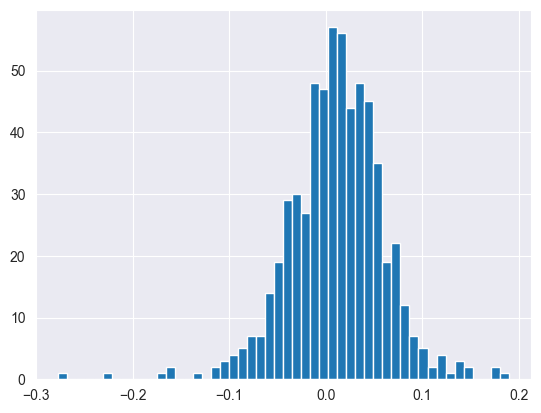

In [81]:
plt.hist(monthly_rets, bins= 50)

(215,)
(733,)


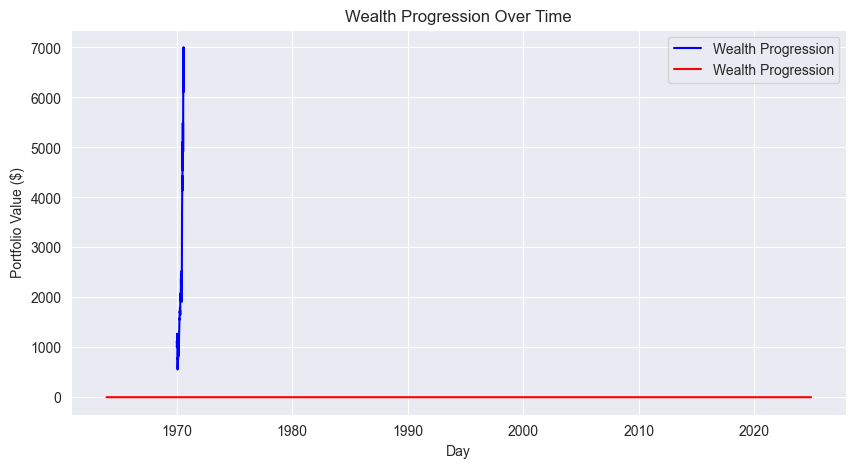

In [79]:
import seaborn as sns
returns = np.array(clean_rets)

initial_wealth = 1000
wealth = initial_wealth * np.cumprod(1 + returns) 
print(wealth.shape)

df_rets = pd.DataFrame({'Day': range(len(returns)), 'Wealth': wealth})

wealth1 = initial_wealth * np.cumprod(1 + df_out.mean(axis=1).values)
print(wealth1.shape)
df_rets1 = pd.DataFrame({'Day': range(len(wealth1)), 'Wealth': wealth1})

# Plot using Seaborn
sns.set_style("darkgrid")
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_rets, x="Day", y="Wealth", color="blue", label="Wealth Progression")
sns.lineplot(data=df_out.mean(axis=1), color="red", label="Wealth Progression")

# Labels and title
plt.xlabel("Day")
plt.ylabel("Portfolio Value ($)")
plt.title("Wealth Progression Over Time")
plt.legend()
plt.show()